# Retirement Planner

---

## Environment Setup

In [4]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [5]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [6]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [7]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [28]:
# Display sample data
df.head()
df.tail()

,AGG,SPY
,close,close
time,,
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86
2019-12-30 00:00:00-05:00,112.630,321.10
2019-12-31 00:00:00-05:00,112.370,321.92


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [37]:
# Calculate the daily roi for the stocks
avg_return=pd.DataFrame(df.pct_change().mean())
avg_return.index=['AGG', 'SPY']
avg_return.columns=['1Yr Mean']
avg_return.head()
# Display sample data
avg_return.loc["AGG","1Yr Mean"]
avg_return.loc["SPY","1Yr Mean"]
print(avg_return.head())

     1Yr Mean
AGG  0.000213
SPY  0.001040


In [23]:
# Compute daily volatility
# Calculate the daily roi for the stocks
OneYr_Vol=pd.DataFrame(df.pct_change().std())
OneYr_Vol.index=['AGG', 'SPY']
OneYr_Vol.columns=['1Yr Vol']
OneYr_Vol.head()
# Display sample data

,1Yr Vol
AGG,0.002089
SPY,0.007820


In [29]:
# Save the last day's closing price
agg_last_closing=df["AGG"]["close"][-1]
spy_last_closing=df["SPY"]["close"][-1]

321.92


In [32]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
number_years = 30  #added parameter for number of years
monte_carlo = pd.DataFrame()

In [80]:
# Run the Monte Carlo Simulation


# Initialize empty DataFrame to hold simulated prices for each simulation

portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_agg_prices = [agg_last_closing]
    simulated_spy_prices = [spy_last_closing]
    
    # Simulate the returns for 252 * 30 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_return.loc["AGG","1Yr Mean"], OneYr_Vol.loc["AGG","1Yr Vol"]))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_return.loc["SPY","1Yr Mean"], OneYr_Vol.loc["SPY","1Yr Vol"]))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60/40 portfolio SPY and AGG)
    weights = [0.4, 0.6]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996843,0.999008,0.995367,1.000397,1.012342,1.010130,0.996505,1.000728,1.010624,1.012490,...,0.998484,1.007499,1.010418,1.003011,0.991617,0.996755,1.007782,1.002387,0.994367,0.997020
2,0.999043,0.999024,0.996192,1.005303,1.008837,1.006938,0.995248,0.998291,1.019182,1.008016,...,1.001571,1.007128,1.013536,1.013082,0.994618,0.989905,1.013992,1.000732,0.994951,1.008902
3,0.993968,0.997019,0.996816,1.006736,1.010268,1.012935,0.994629,1.000372,1.023057,1.006325,...,1.006877,1.007426,1.015806,1.009254,0.984450,0.998607,1.016249,0.996268,1.004078,1.013797
4,1.001468,0.993934,0.995279,1.011144,1.005963,1.020848,1.000627,0.992154,1.026933,1.009787,...,1.008476,1.017659,1.024718,1.016194,0.986391,1.006905,1.017386,0.995823,1.002472,1.010662


In [81]:
monte_carlo.tail()
portfolio_cumulative_returns.iloc[-1,:].mean()

214.1888142924587

In [82]:
# Check that the simulation ran successfully
print(f"Monte Carlo Estimates Mean and Median: {round(portfolio_cumulative_returns.iloc[-1,:].median(),2)}, {round(portfolio_cumulative_returns.iloc[-1,:].mean(),2)}")
print(f"Base Estimates {(1+avg_return.T.dot(weights))**number_records-1}")
# The code above compares the mean and median of the Cumulative Returns Monte Carlo distribution with a base case i.e. 1 day mean AGG and SPY return compounded over 252*30 trading days


Monte Carlo Estimates Mean and Median: 198.97, 214.19
Base Estimates 1Yr Mean    211.623472
dtype: float64


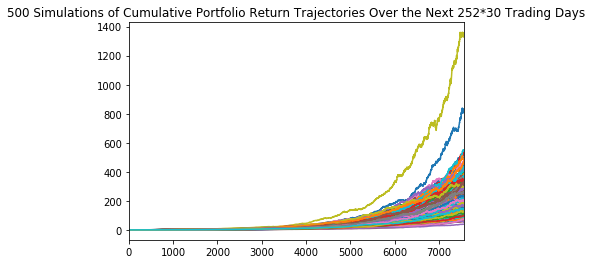

In [83]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252*30 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

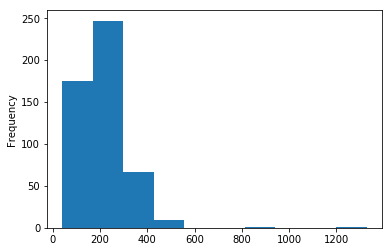

In [88]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
portfolio_cumulative_returns.iloc[-1,:].describe()
portfolio_cumulative_returns.iloc[-1,:].plot(kind="hist",bins=10)

In [188]:
portfolio_cumulative_returns.iloc[-1,:].value_counts(bins=10) / len(portfolio_cumulative_returns.iloc[-1,:])

(169.11, 297.999]               0.494
(38.931000000000004, 169.11]    0.350
(297.999, 426.888]              0.134
(426.888, 555.776]              0.018
(1200.221, 1329.109]            0.002
(813.554, 942.443]              0.002
(1071.332, 1200.221]            0.000
(942.443, 1071.332]             0.000
(684.665, 813.554]              0.000
(555.776, 684.665]              0.000
Name: 7560, dtype: float64

In [179]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
portfolio_cumulative_returns.iloc[-1,:] # return at 30 years
#portfolio_cumulative_returns.iloc[-253,:] # return at 20 years

0      179.829066
1      182.533196
2      104.741718
3      229.235482
4      107.457944
5      153.169827
6      122.264721
7      223.036148
8      222.321766
9      165.429630
10     229.884941
11     247.097045
12     270.768113
13     151.571943
14     273.681752
15     157.262910
16     138.585630
17     119.952204
18     233.794892
19     130.280043
20     314.824202
21     126.896770
22     193.772271
23     186.839623
24     289.883393
25     184.215655
26     143.369262
27     224.060877
28     364.964007
29     158.338021
          ...    
470    217.794616
471    222.060611
472    340.869484
473    335.688994
474    120.783989
475    243.210441
476    189.789209
477    296.392560
478    187.177721
479    234.691573
480    151.740514
481    145.622687
482    119.873898
483    345.831392
484    162.352295
485    329.330366
486    211.803739
487    307.598639
488    296.550029
489    231.417241
490    232.850942
491    471.148776
492    102.621660
493    100.038934
494    285

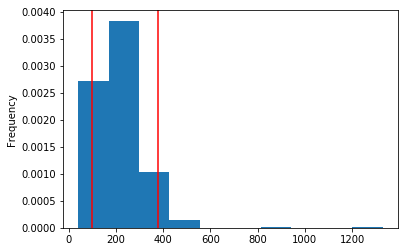

In [178]:
# Display the 90% confidence interval for the ending returns
ending_cumulative_returns=portfolio_cumulative_returns.iloc[-1,:]
confidence_interval_30 = ending_cumulative_returns.quantile(q=[0.05, 0.95])
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval_30.iloc[0], color='r')
plt.axvline(confidence_interval_30.iloc[1], color='r')

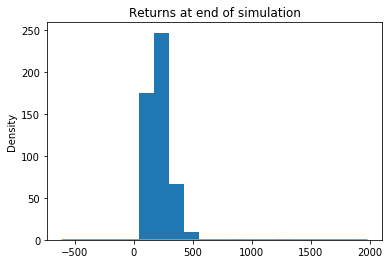

In [105]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind="hist",legend=None, title="Returns at end of simulation")
ending_cumulative_returns.plot(kind="kde",legend=None, title="Returns at end of simulation")

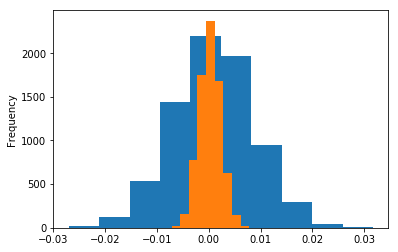

In [187]:
monte_carlo["SPY prices"].pct_change().plot(kind="hist") #confirms daily distribution of prices for a single sample
monte_carlo["AGG prices"].pct_change().plot(kind="hist") #confirms daily distribution of prices for a single sample

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

[Text(0, 0, '10th'), Text(0, 0, '50th'), Text(0, 0, '95th')]

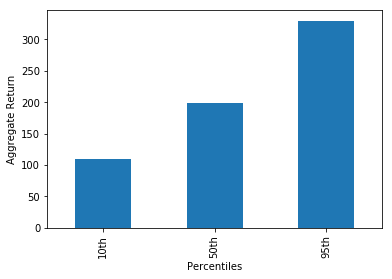

In [134]:
# Compute cumulative returns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
ax=ending_cumulative_returns.quantile(q=[.1,.5,.9]).plot(kind="bar")
#ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set(xlabel="Percentiles", ylabel="Aggregate Return")
ax.set_xticklabels(['10th','50th','95th'])

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [175]:
# Set initial investment
initial_investment=20000
# Compute expected portfolio return
portfolio_return_dollars=ending_cumulative_returns.quantile(q=[.1,.5,.9])*initial_investment
output=zip(['10th %ile','50th %ile','95th %ile'],round(portfolio_return_dollars,0))
list(output)


[('10th %ile', 2193483.0), ('50th %ile', 3979458.0), ('95th %ile', 6594179.0)]

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [ ]:
# Set Plaid's projected income

# Calculate the 4% withdrawal for the ending return as retirement income

# Determine if the retirement income meets or exceeds the current projected income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

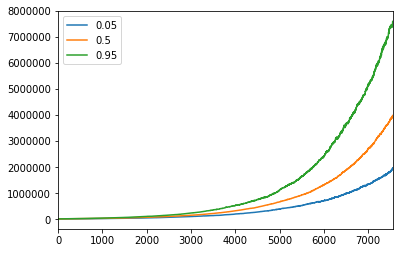

In [199]:
# Compute projected returns
NewReturns=portfolio_cumulative_returns.T.quantile([.05, .5, 0.95])*initial_investment
NewReturns.T.plot()
#portfolio_cumulative_returns.shape
# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
